#Data Exploration 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import unicodedata
import re
from scipy.sparse import csr_matrix, hstack
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

data = pd.read_csv("assignment_dataset.csv") 
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,variety,designation,country,province,description,price,winery,taster_name,points
0,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Vulkà Bianco,Italy,Sicily & Sardinia,"Aromas include tropical fruit, broom, brimston...",NaN,Nicosia,Kerin O’Keefe,87
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87
2,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,NaN,US,Oregon,"Tart and snappy, the flavors of lime flesh and...",14.0,Rainstorm,Paul Gregutt,87
3,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,Reserve Late Harvest,US,Michigan,"Pineapple rind, lemon pith and orange blossom ...",13.0,St. Julian,Alexander Peartree,87
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Vintner's Reserve Wild Child Block,US,Oregon,"Much like the regular bottling from 2012, this...",65.0,Sweet Cheeks,Paul Gregutt,87


In [2]:
data.shape

(129971, 10)

####For the purposes of these specific questions, there is no point keeping duplicates on the dataset. It will only askew the analysis.

In [3]:
data.loc[data.duplicated()].shape

(9983, 10)

In [0]:
data.drop_duplicates(inplace = True)

In [5]:
data.describe()

,price,points
count,111593.000000,119988.000000
mean,35.620747,88.442236
std,42.103728,3.092915
min,4.000000,80.000000
25%,17.000000,86.000000
50%,25.000000,88.000000
75%,42.000000,91.000000
max,3300.000000,100.000000


Checking the correlation between price and points.

In [7]:
data['price'].corr(data['points'])

0.41653398334645453

In [8]:
def missing_rep(df):
    miss = df.isna().sum()
    miss = miss[miss>0]
    miss_p = miss/df.shape[0]

    return pd.DataFrame({"Missings" : miss, "Proportion of Missings" : miss_p})

missing_rep(data)

,Missings,Proportion of Missings
variety,1,0.000008
designation,34545,0.287904
country,59,0.000492
province,59,0.000492
price,8395,0.069965
taster_name,24917,0.207662


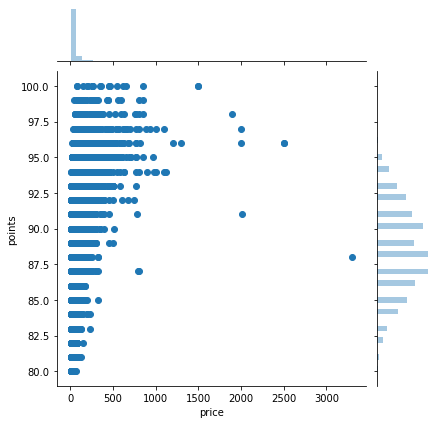

In [9]:
sns.jointplot(x ='price', y ='points', data = data) 

Having a better look at the extreme values.

In [10]:
out_df = data[data['price']>1200]
out = out_df.shape[0]
total = data.shape[0]
out_p = out/total

print("Outliers = ", out)
print("Proportion of Outliers = ", out_p)

Outliers =  10
Proportion of Outliers =  8.334166750008334e-05


The extreme values seem to be ouliers and may bias the model. They'll be removed from the analysis.

In [11]:
data = pd.concat([data,out_df]).drop_duplicates(keep=False)
data.shape

(119978, 10)

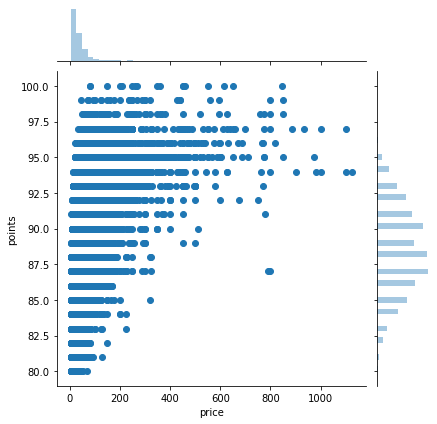

In [12]:
data = data[data['price']<1200]
sns.jointplot(x ='price', y ='points', data = data) 

##### Handling missing values

In [0]:
def missing_values_handler(data): 
    data['variety'].fillna(value='missing', inplace=True) 
    data['designation'].fillna(value='missing', inplace=True) 
    data['country'].fillna(value='missing', inplace=True) 
    data['province'].fillna(value='missing', inplace=True)
    data['price'].fillna(value='missing', inplace=True)  
    data['taster_name'].fillna(value='missing', inplace=True) 

    
missing_values_handler(data)

In [15]:
missing_rep(data)

,Missings,Proportion of Missings


#Question 1

In [16]:
data_q1 = data[data.price != 'missing']

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Checking the distribution of the prices. It's right skewed.

Text(0.5, 1.0, 'Price Distribution')

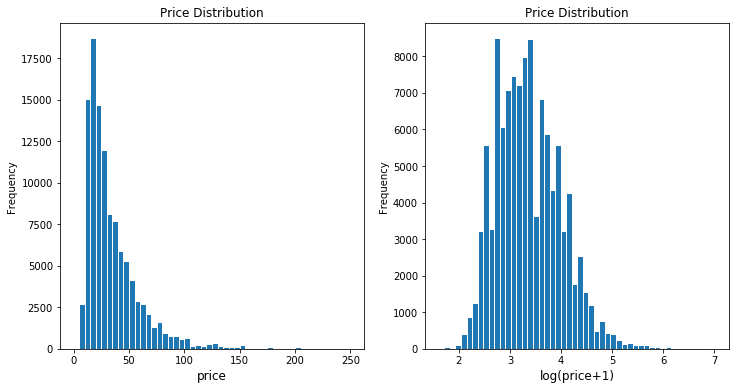

In [17]:
plt.subplot(1, 2, 1)
(data_q1['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
np.log(data_q1['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [18]:
data_q1['price/points'] = data_q1['price']/data_q1['points']
data_q1.head()

,title,variety,designation,country,province,description,price,winery,taster_name,points,price/points
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87,0.172414
2,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,missing,US,Oregon,"Tart and snappy, the flavors of lime flesh and...",14.0,Rainstorm,Paul Gregutt,87,0.160920
3,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,Reserve Late Harvest,US,Michigan,"Pineapple rind, lemon pith and orange blossom ...",13.0,St. Julian,Alexander Peartree,87,0.149425
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Vintner's Reserve Wild Child Block,US,Oregon,"Much like the regular bottling from 2012, this...",65.0,Sweet Cheeks,Paul Gregutt,87,0.747126
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Ars In Vitro,Spain,Northern Spain,Blackberry and raspberry aromas show a typical...,15.0,Tandem,Michael Schachner,87,0.172414


In [19]:
wine_df = data_q1.groupby('title').agg({'title' : ['count']})
wine_df.columns = ['count'] 
wine_df[wine_df['count']>3]

,count
title,
Bailly-Lapierre NV Brut (Crémant de Bourgogne),6
Boizel NV Brut Réserve (Champagne),4
Chandon NV Brut Classic Sparkling (California),4
Chandon NV Rosé Sparkling (California),5
Delamotte NV Brut (Champagne),4
Domaine Charles Baur NV Brut Sparkling (Crémant d'Alsace),4
Ferrari NV Rosé Sparkling (Trento),4
Freixenet NV Carta Nevada Brut Sparkling (Cava),4
Freixenet NV Cordon Negro Brut Sparkling (Cava),4


In [20]:
data_q1[data_q1.title == 'Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)']

,title,variety,designation,country,province,description,price,winery,taster_name,points,price/points
3209,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Sonoma Brut,US,California,"Creamy, lush and somewhat robust, this dry spa...",22.0,Gloria Ferrer,Virginie Boone,90,0.244444
4399,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Sonoma Brut,US,California,"Made predominantly from Pinot Noir, this is an...",22.0,Gloria Ferrer,Virginie Boone,88,0.250000
27773,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Sonoma Brut,US,California,A wonderfully drinkable sparkling wine that ap...,20.0,Gloria Ferrer,missing,90,0.222222
63179,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Sonoma Brut,US,California,"Made from mostly Pinot Noir grapes, with an ad...",22.0,Gloria Ferrer,Virginie Boone,92,0.239130
81563,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Sonoma Brut,US,California,This wine shows lots of finesse for the price....,24.0,Gloria Ferrer,missing,89,0.269663
94321,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Sonoma Brut,US,California,"A bit rough and scouring in texture, this tast...",20.0,Gloria Ferrer,missing,85,0.235294
100738,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Sonoma Brut,US,California,"A good, dry and elegant bubbly. Shows crisp fl...",20.0,Gloria Ferrer,missing,89,0.224719
109001,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Sonoma Brut,US,California,From almost 92% Pinot Noir with the remainder ...,22.0,Gloria Ferrer,Virginie Boone,88,0.250000
122208,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Sparkling Blend,Sonoma Brut,US,California,This bubbly is rich in cherry and raspberry fr...,20.0,Gloria Ferrer,missing,86,0.232558


#### Interesting fact is that there are wines that have almost all the same attributes, but they vary only on the description, price and points.

In [21]:
data_q1.describe()

,price,points,price/points
count,111582.000000,111582.000000,111582.000000
mean,35.429666,88.413239,0.394593
std,36.989593,3.097866,0.392946
min,4.000000,80.000000,0.046512
25%,17.000000,86.000000,0.195402
50%,25.000000,88.000000,0.290698
75%,42.000000,91.000000,0.476190
max,1125.000000,100.000000,11.968085


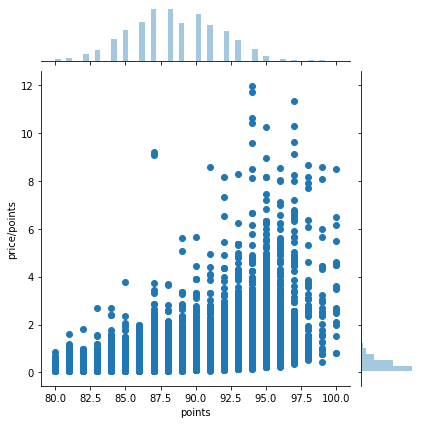

In [22]:
sns.jointplot(x ='points', y ='price/points', data = data_q1)

In [23]:
winery_df = data_q1.groupby('winery').agg({'price/points' : ['mean']})
winery_df.columns = ['avg_price/points'] 
winery_df.describe()

,avg_price/points
count,15853.000000
mean,0.359730
std,0.318750
min,0.047250
25%,0.193036
50%,0.280988
75%,0.425933
max,8.247423


Based on the distribution of the prices/points, I'm going to classify a winery in 3 categories:


*   **1 = Normal price**: Represents 1st and 2nd percentile of the distribution where the wineries double the price of the bottle.
*   **2 = Reasonably high price**: Represents the 3rd percentile of the distribution where the wineries triple the price of the bottle.
*   **3 = High price**: Represents the 4rd percentile of the distribution where the wineries quadruple the price of the bottle.

The choice of this values was arbitrary, mostly based on searches of how wineries price their wines.

In [24]:
winery_df['classification']= 0
winery_df['classification'].loc[winery_df['avg_price/points'] >= 0.425933] = 3
winery_df['classification'].loc[winery_df['avg_price/points'] < 0.425933] = 2
winery_df['classification'].loc[winery_df['avg_price/points'] < 0.280988] = 1

winery_df = winery_df.reset_index()

winery_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,winery,avg_price/points,classification
0,1+1=3,0.208921,1
1,10 Knots,0.298519,2
2,100 Percent Wine,0.208612,1
3,1000 Stories,0.209951,1
4,1070 Green,0.284091,2


In [25]:
 data_q1 = pd.merge(data_q1, winery_df, on=['winery','winery'])
 data_q1.head()

,title,variety,designation,country,province,description,price,winery,taster_name,points,price/points,avg_price/points,classification
0,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87,0.172414,0.244898,1
1,Quinta dos Avidagos 2015 Lote 138 Red (Douro),Portuguese Red,Lote 138,Portugal,Douro,This wine is light in tannins and ripe in frui...,11.0,Quinta dos Avidagos,Roger Voss,85,0.129412,0.244898,1
2,Quinta dos Avidagos 2014 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,Towards the western end of the Douro vineyards...,15.0,Quinta dos Avidagos,Roger Voss,87,0.172414,0.244898,1
3,Quinta dos Avidagos 2011 Lenuma Red (Douro),Portuguese Red,Lenuma,Portugal,Douro,This Avidagos vineyard in the Corgo River Vall...,65.0,Quinta dos Avidagos,Roger Voss,93,0.698925,0.244898,1
4,Quinta dos Avidagos 2012 Premium Red (Douro),Portuguese Red,Premium,Portugal,Douro,"This is a balanced, ripe wine. Soft tannins su...",29.0,Quinta dos Avidagos,Roger Voss,87,0.333333,0.244898,1


Therefore, the estimation of the prices is based on description of the categories previously explained.

In [26]:
data_q1['price_estimation'] = data_q1['price']
data_q1['price_estimation'].loc[data_q1['classification'] == 1] = data_q1['price_estimation'].loc[data_q1['classification'] == 1]/2
data_q1['price_estimation'].loc[data_q1['classification'] == 2] = data_q1['price_estimation'].loc[data_q1['classification'] == 2]/3 
data_q1['price_estimation'].loc[data_q1['classification'] == 3] = data_q1['price_estimation'].loc[data_q1['classification'] == 3]/4
data_q1.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,title,variety,designation,country,province,description,price,winery,taster_name,points,price/points,avg_price/points,classification,price_estimation
0,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87,0.172414,0.244898,1,7.5
1,Quinta dos Avidagos 2015 Lote 138 Red (Douro),Portuguese Red,Lote 138,Portugal,Douro,This wine is light in tannins and ripe in frui...,11.0,Quinta dos Avidagos,Roger Voss,85,0.129412,0.244898,1,5.5
2,Quinta dos Avidagos 2014 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,Towards the western end of the Douro vineyards...,15.0,Quinta dos Avidagos,Roger Voss,87,0.172414,0.244898,1,7.5
3,Quinta dos Avidagos 2011 Lenuma Red (Douro),Portuguese Red,Lenuma,Portugal,Douro,This Avidagos vineyard in the Corgo River Vall...,65.0,Quinta dos Avidagos,Roger Voss,93,0.698925,0.244898,1,32.5
4,Quinta dos Avidagos 2012 Premium Red (Douro),Portuguese Red,Premium,Portugal,Douro,"This is a balanced, ripe wine. Soft tannins su...",29.0,Quinta dos Avidagos,Roger Voss,87,0.333333,0.244898,1,14.5


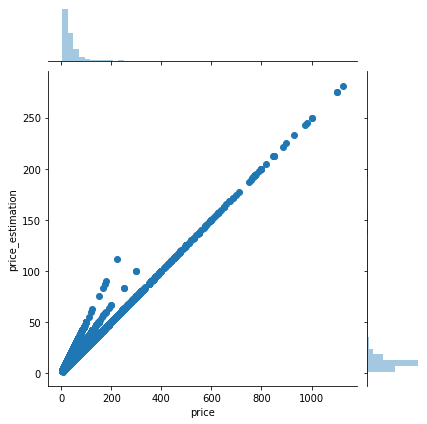

In [27]:
sns.jointplot(x ='price', y ='price_estimation', data = data_q1)


#Question 2

Since the percentage of missing countries, province, designation is insignificant, the rows of invalid values will be dropped for this question.

In [28]:
data_q2 = data[data.country != 'missing']
data_q2 = data_q2[data.variety != 'missing']
data_q2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,title,variety,designation,country,province,description,price,winery,taster_name,points
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87
2,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,missing,US,Oregon,"Tart and snappy, the flavors of lime flesh and...",14.0,Rainstorm,Paul Gregutt,87
3,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,Reserve Late Harvest,US,Michigan,"Pineapple rind, lemon pith and orange blossom ...",13.0,St. Julian,Alexander Peartree,87
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Vintner's Reserve Wild Child Block,US,Oregon,"Much like the regular bottling from 2012, this...",65.0,Sweet Cheeks,Paul Gregutt,87
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Ars In Vitro,Spain,Northern Spain,Blackberry and raspberry aromas show a typical...,15.0,Tandem,Michael Schachner,87
...,...,...,...,...,...,...,...,...,...,...
129966,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Brauneberger Juffer-Sonnenuhr Spätlese,Germany,Mosel,Notes of honeysuckle and cantaloupe sweeten th...,28.0,Dr. H. Thanisch (Erben Müller-Burggraef),Anna Lee C. Iijima,90
129967,Citation 2004 Pinot Noir (Oregon),Pinot Noir,missing,US,Oregon,Citation is given as much as a decade of bottl...,75.0,Citation,Paul Gregutt,90
129968,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Kritt,France,Alsace,Well-drained gravel soil gives this wine its c...,30.0,Domaine Gresser,Roger Voss,90
129969,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,missing,France,Alsace,"A dry style of Pinot Gris, this is crisp with ...",32.0,Domaine Marcel Deiss,Roger Voss,90


In [29]:
data.groupby('variety').agg({'title' : ['count'], 'price' : ['mean'], 'points' : ['mean']})

,title,price,points
,count,mean,mean
variety,,,
Abouriou,3,35.000000,87.666667
Agiorgitiko,56,23.767857,86.982143
Aglianico,274,39.459854,89.401460
Aidani,1,27.000000,82.000000
Airen,3,9.000000,81.666667
...,...,...,...
Zlahtina,2,14.500000,86.000000
Zweigelt,158,21.544304,88.430380


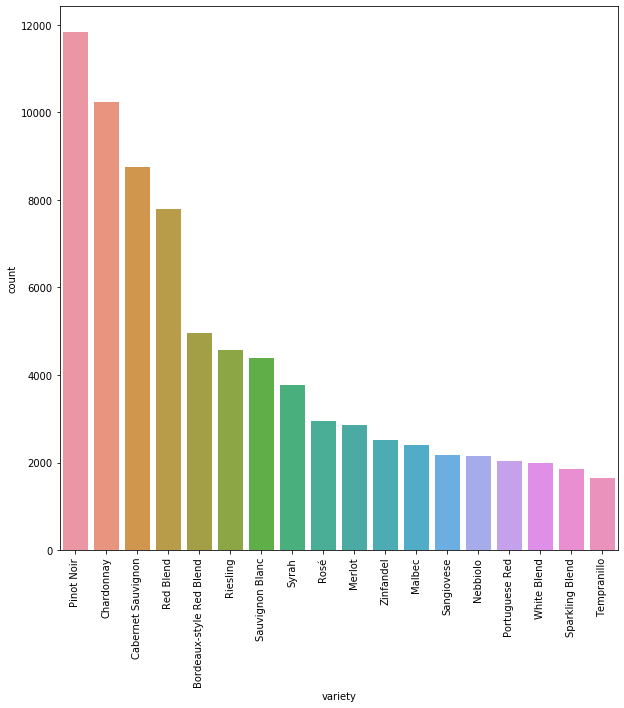

In [30]:
variety_df = data_q2.groupby('variety').filter(lambda x: len(x) > 1500)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (10, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

After seeing the data, I have chosen apply NLP to decide which wines are similar and, consequently, identifying the areas that are similar for production. I'm doing unsupervised learning based on the variety.

## First step: Text cleaning and preprocessing

For the simility analysis, the rows that are missing the price will be kept because their other attributes may be meaningful for the analysis.

In [31]:
data_q2.head()

,title,variety,designation,country,province,description,price,winery,taster_name,points
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87
2,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,missing,US,Oregon,"Tart and snappy, the flavors of lime flesh and...",14.0,Rainstorm,Paul Gregutt,87
3,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,Reserve Late Harvest,US,Michigan,"Pineapple rind, lemon pith and orange blossom ...",13.0,St. Julian,Alexander Peartree,87
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Vintner's Reserve Wild Child Block,US,Oregon,"Much like the regular bottling from 2012, this...",65.0,Sweet Cheeks,Paul Gregutt,87
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Ars In Vitro,Spain,Northern Spain,Blackberry and raspberry aromas show a typical...,15.0,Tandem,Michael Schachner,87


In [0]:
# Bag of words
def get_all_words(text):
    all_words = []
    for words in text:
        all_words.extend(words.split())
    return all_words

def get_bag_of_words(all_words):
    return nltk.FreqDist(all_words)

In [33]:
all_words = get_all_words(data_q2["variety"])
bag_of_words = get_bag_of_words(all_words)
word_features = bag_of_words.keys()
bag_of_words.most_common(10)

[('Blend', 20741),
 ('Red', 16111),
 ('Pinot', 14730),
 ('Sauvignon', 13777),
 ('Noir', 11870),
 ('Cabernet', 10435),
 ('Chardonnay', 10236),
 ('Blanc', 5619),
 ('Bordeaux-style', 5585),
 ('Riesling', 4592)]

In [0]:
def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)

In [0]:
def find_white(tokens):
    r = [word for word in tokens if " " in tokens]
    if len(r)>0:
      print(r)
    return tokens

In [36]:
# Remove punctuation and tokenize
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer() 
stopwords = stopwords.words('english')
stopwords.append('missing')

data_q2.variety = data_q2.variety.apply(lambda x: x.lower())

data_q2.variety = data_q2.variety.apply(lambda x: strip_accents(x))

# At first I wasn't going to remove numbers, but then I realized that I might be for the best
data_q2.variety = data_q2.variety.apply(lambda x: re.sub('[0-9]+', '', x))

data_q2.variety = data_q2.variety.apply(lambda x: tokenizer.tokenize(x))

data_q2.variety = data_q2.variety.apply(lambda x: find_white(x))

data_q2.head()

,title,variety,designation,country,province,description,price,winery,taster_name,points
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"[portuguese, red]",Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"[pinot, gris]",missing,US,Oregon,"Tart and snappy, the flavors of lime flesh and...",14.0,Rainstorm,Paul Gregutt,87
3,St. Julian 2013 Reserve Late Harvest Riesling ...,[riesling],Reserve Late Harvest,US,Michigan,"Pineapple rind, lemon pith and orange blossom ...",13.0,St. Julian,Alexander Peartree,87
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"[pinot, noir]",Vintner's Reserve Wild Child Block,US,Oregon,"Much like the regular bottling from 2012, this...",65.0,Sweet Cheeks,Paul Gregutt,87
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,"[tempranillo, merlot]",Ars In Vitro,Spain,Northern Spain,Blackberry and raspberry aromas show a typical...,15.0,Tandem,Michael Schachner,87


In [0]:
def stop_words(tokens):
    tokens = [word for word in tokens if word not in stopwords]
    return tokens

def lemmatize(tokens):
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

def stem(tokens):
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [0]:
data_q2.variety = data_q2.variety.apply(lambda x: stop_words(x))

data_q2.variety = data_q2.variety.apply(lambda x: lemmatize(x))

data_q2.variety = data_q2.variety.apply(lambda x: stem(x))

In [39]:
data_q2.head()

,title,variety,designation,country,province,description,price,winery,taster_name,points
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"[portugues, red]",Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"[pinot, gris]",missing,US,Oregon,"Tart and snappy, the flavors of lime flesh and...",14.0,Rainstorm,Paul Gregutt,87
3,St. Julian 2013 Reserve Late Harvest Riesling ...,[riesl],Reserve Late Harvest,US,Michigan,"Pineapple rind, lemon pith and orange blossom ...",13.0,St. Julian,Alexander Peartree,87
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"[pinot, noir]",Vintner's Reserve Wild Child Block,US,Oregon,"Much like the regular bottling from 2012, this...",65.0,Sweet Cheeks,Paul Gregutt,87
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,"[tempranillo, merlot]",Ars In Vitro,Spain,Northern Spain,Blackberry and raspberry aromas show a typical...,15.0,Tandem,Michael Schachner,87


## Second step: Text modeling (clustering)

In [0]:
# Define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), preprocessor=' '.join)


In [41]:
tfidf_matrix = tfidf_vectorizer.fit_transform(data_q2['variety'])
terms = tfidf_vectorizer.get_feature_names()
print(tfidf_matrix.shape)
print(terms)

(111526, 950)
['abouriou', 'affil', 'agiorgitiko', 'aglianico', 'aidani', 'airen', 'albana', 'albanello', 'albarino', 'albarossa', 'aleatico', 'alejandria', 'alexandri', 'alexandria', 'alfrocheiro', 'alicant', 'alicant bouschet', 'aligot', 'alsac', 'alsac white', 'alsac white blend', 'altess', 'alvarelhao', 'alvarinho', 'alvarinho chardonnay', 'amarela', 'angevin', 'ansonica', 'antao', 'antao vaz', 'appl', 'aragon', 'aragonez', 'argaman', 'arinto', 'arnei', 'asprinio', 'assyrtico', 'assyrtiko', 'athiri', 'austrian', 'austrian red', 'austrian red blend', 'austrian white', 'austrian white blend', 'auxerroi', 'avesso', 'avola', 'azal', 'babic', 'babosa', 'babosa negro', 'baco', 'baco noir', 'baga', 'baga touriga', 'baga touriga nacion', 'barbera', 'barbera nebbiolo', 'barroca', 'bastardo', 'bianca', 'biancal', 'bianco', 'biancolella', 'bical', 'black', 'black monukka', 'black muscat', 'blanc', 'blanc assyrtiko', 'blanc chardonnay', 'blanc chenin', 'blanc chenin blanc', 'blanc colombard', 

Remove features with document frequency <= 1.

In [42]:
mask = np.array(np.clip(tfidf_matrix.getnnz(axis=0) - 1, 0, 1), dtype=bool)
tfidf_matrix = tfidf_matrix[:, mask]
tfidf_matrix

<111526x770 sparse matrix of type '<class 'numpy.float64'>'
	with 281292 stored elements in Compressed Sparse Row format>

In [43]:
km = KMeans(n_clusters = 18, n_init = 5, n_jobs = -1)
km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=18, n_init=5, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
clusters = km.labels_.tolist()

In [45]:
common_words = km.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(terms[word] for word in centroid))

0 : petit, barbera nebbiolo, perricon, spatburgund, fernao, foll blanch, foll, fino, fina, fiano
1 : moscatel de alejandria, mavrotragano, montepulciano, spatburgund, feteasca, forcalla, foll blanch, foll, fino, fina
2 : bombino nero, blauer, perricon, spatburgund, fernao pire, forcalla, foll blanch, foll, fino, fina
3 : provenc red, spatburgund, garnacha, foll blanch, foll, fino, fina, fiano, feteasca regala, feteasca neagra
4 : okuzgozu, spatburgund, franc cabernet, forcalla, foll blanch, foll, fino, fina, fiano, feteasca regala
5 : negroamaro, negro, negrett, prie, prie blanc, premsal, nebbiolo, neagra, blanc petit, spatburgund
6 : cao, garnacha blanca, forcalla, foll blanch, foll, fino, fina, fiano, feteasca regala, feteasca neagra
7 : papaskarasi, rhone style, portugues rose, portugues sparkl, montepulciano, semillon, erbaluc, blanc petit, frappato, moscadello
8 : blanc viognier, blanc semillon, blanc verdejo, prie blanc, prie, premsal, nebbiolo, neagra, blanc petit, feteasca rega

In [0]:
data_q2['cluster'] = km.labels_

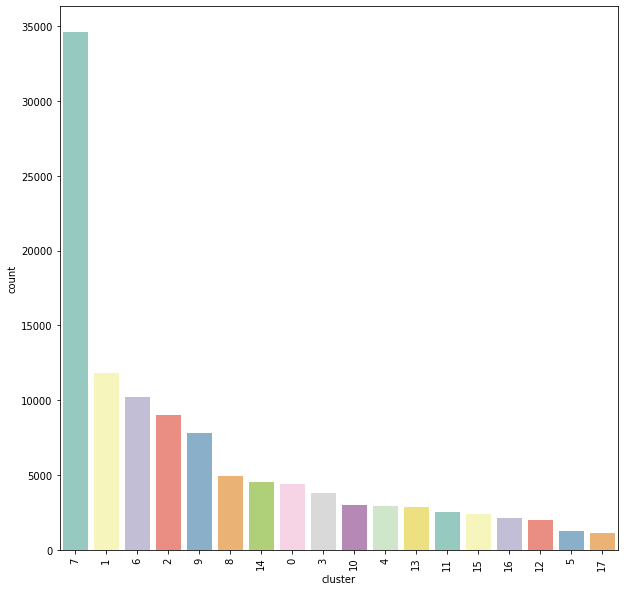

In [47]:
cluster_df = data_q2.groupby('cluster').filter(lambda x: len(x) != 0)
clusters = cluster_df['cluster'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (10, 10))
sns.countplot(x = cluster_df['cluster'], palette="Set3", order = clusters, ax = ax)
plt.xticks(rotation = 90)
plt.show()

## Third step: Wine selection

After segmenting the wines based on their variety and creating 18 regions of simility, now it's possible to create a wine list of each region. I created 4 categories of customers: 


*   **Wine experimenter**: Clients who are only willing to spend a small amount of money on a wine bottle.
*   **Wine lover**: Clients who want a balance between price and quality.
*   **Wine connoisseur**: Clients who want the wines with the best evaluations.
*   **Wine investor**: Clients who do not care about the price and just want the most expensive.

I created a recommendation list of Top 3 wines for each region according to customer category.



By the way, since now the price is important for the analysis and they represent less than 7% of the data, I decided to no include them.

In [48]:
data_q2_final = data_q2[data_q2.price != 'missing']

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [49]:
data_q2_final.shape

(111526, 11)

In [50]:
data_q2_final['price/points'] = data_q2_final['price']/data_q2_final['points']
data_q2_final.head()

,title,variety,designation,country,province,description,price,winery,taster_name,points,cluster,price/points
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"[portugues, red]",Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87,12,0.172414
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"[pinot, gris]",missing,US,Oregon,"Tart and snappy, the flavors of lime flesh and...",14.0,Rainstorm,Paul Gregutt,87,7,0.160920
3,St. Julian 2013 Reserve Late Harvest Riesling ...,[riesl],Reserve Late Harvest,US,Michigan,"Pineapple rind, lemon pith and orange blossom ...",13.0,St. Julian,Alexander Peartree,87,14,0.149425
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"[pinot, noir]",Vintner's Reserve Wild Child Block,US,Oregon,"Much like the regular bottling from 2012, this...",65.0,Sweet Cheeks,Paul Gregutt,87,1,0.747126
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,"[tempranillo, merlot]",Ars In Vitro,Spain,Northern Spain,Blackberry and raspberry aromas show a typical...,15.0,Tandem,Michael Schachner,87,7,0.172414


The following are the recommentions for each category. 




### Wine investors

In [51]:
data_q2_final = data_q2_final.groupby(["cluster"]).apply(lambda x: x.sort_values(["price"], ascending = False)).reset_index(drop=True)
result = data_q2_final.groupby('cluster').head(3)
result[['title', 'variety', 'price', 'cluster']]

,title,variety,price,cluster
0,Château Tour des Gendres 2007 Anthologia Sauvi...,"[sauvignon, blanc]",135.0,0
1,Château de Tracy 2008 Haute Densité (Pouilly-...,"[sauvignon, blanc]",110.0,0
2,Pascal Jolivet 2010 Exception (Sancerre),"[sauvignon, blanc]",100.0,0
4400,Domaine du Comte Liger-Belair 2006 La Romanée,"[pinot, noir]",1125.0,1
4401,Domaine Jacques Prieur 2014 Musigny,"[pinot, noir]",973.0,1
4402,Louis Latour 2015 Les Quatre Journaux (Romané...,"[pinot, noir]",650.0,1
16231,Yao Ming 2011 Family Reserve Cabernet Sauvigno...,"[cabernet, sauvignon]",625.0,2
16232,Yao Ming 2009 Family Reserve Cabernet Sauvigno...,"[cabernet, sauvignon]",625.0,2
16233,Yao Ming 2010 Family Reserve Cabernet Sauvigno...,"[cabernet, sauvignon]",625.0,2
25268,Law 2013 Intrepid Syrah (Paso Robles),[syrah],750.0,3


### Wine connoisseur

In [52]:
data_q2_final = data_q2_final.groupby(["cluster"]).apply(lambda x: x.sort_values(["points"], ascending = False)).reset_index(drop=True)
result = data_q2_final.groupby('cluster').head(3)
result[['title', 'variety', 'points', 'cluster']]

,title,variety,points,cluster
0,Illumination 2008 Sauvignon Blanc (Napa Valley),"[sauvignon, blanc]",95,0
1,Henri Bourgeois 2012 Jadis (Sancerre),"[sauvignon, blanc]",95,0
2,Grgich Hills 2012 Essence Estate Grown Sauvign...,"[sauvignon, blanc]",95,0
4400,Williams Selyem 2010 Hirsch Vineyard Pinot Noi...,"[pinot, noir]",99,1
4401,Williams Selyem 2009 Precious Mountain Vineyar...,"[pinot, noir]",99,1
4402,Wayfarer 2014 The Traveler Pinot Noir (Fort Ro...,"[pinot, noir]",98,1
16231,Cardinale 2006 Cabernet Sauvignon (Napa Valley),"[cabernet, sauvignon]",100,2
16232,Quilceda Creek 2008 Cabernet Sauvignon (Columb...,"[cabernet, sauvignon]",99,2
16233,David Arthur 2009 Elevation 1147 Estate Cabern...,"[cabernet, sauvignon]",99,2
25268,Charles Smith 2006 Royal City Syrah (Columbia ...,[syrah],100,3


### Wine lovers

In [53]:
data_q2_final = data_q2_final.groupby(["cluster"]).apply(lambda x: x.sort_values(["price/points"], ascending = False)).reset_index(drop=True)
result = data_q2_final.groupby('cluster').head(3)
result[['title', 'variety', 'price/points', 'cluster']]

,title,variety,price/points,cluster
0,Château Tour des Gendres 2007 Anthologia Sauvi...,"[sauvignon, blanc]",1.436170,0
1,Château de Tracy 2008 Haute Densité (Pouilly-...,"[sauvignon, blanc]",1.182796,0
2,Château de Tracy 2004 Haute Densité (Pouilly-...,"[sauvignon, blanc]",1.076087,0
4400,Domaine du Comte Liger-Belair 2006 La Romanée,"[pinot, noir]",11.968085,1
4401,Domaine Jacques Prieur 2014 Musigny,"[pinot, noir]",10.242105,1
4402,Louis Latour 2015 Les Quatre Journaux (Romané...,"[pinot, noir]",6.842105,1
16231,Yao Ming 2011 Family Reserve Cabernet Sauvigno...,"[cabernet, sauvignon]",6.648936,2
16232,Yao Ming 2009 Family Reserve Cabernet Sauvigno...,"[cabernet, sauvignon]",6.443299,2
16233,Yao Ming 2010 Family Reserve Cabernet Sauvigno...,"[cabernet, sauvignon]",6.377551,2
25268,Law 2013 Intrepid Syrah (Paso Robles),[syrah],8.152174,3


### Wine experimenters

In [54]:
data_q2_final = data_q2_final.groupby(["cluster"]).apply(lambda x: x.sort_values(["price"], ascending = False)).reset_index(drop=True)
result = data_q2_final.groupby('cluster').tail(3)
result[['title', 'variety', 'price', 'cluster']]

,title,variety,price,cluster
4397,Le Pépin 2015 Sauvignon Blanc (Vin de France),"[sauvignon, blanc]",6.0,0
4398,Woodbridge 2001 Sauvignon Blanc (California),"[sauvignon, blanc]",6.0,0
4399,In Situ 2008 Reserva Sauvignon Blanc (Aconcagu...,"[sauvignon, blanc]",5.0,0
16228,Morandé 2002 Pinot Noir (Casablanca Valley),"[pinot, noir]",7.0,1
16229,Backhouse 2010 Pinot Noir (California),"[pinot, noir]",7.0,1
16230,French Rabbit 2007 Pinot Noir (Vin de Pays d'Oc),"[pinot, noir]",5.0,1
25265,San Pedro 2002 Gato Negro Cabernet Sauvignon (...,"[cabernet, sauvignon]",5.0,2
25266,Terrenal 2012 Estate Bottled Cabernet Sauvigno...,"[cabernet, sauvignon]",5.0,2
25267,Terrenal 2010 Cabernet Sauvignon (Yecla),"[cabernet, sauvignon]",4.0,2
29043,Calvet 1998 Syrah (Vin de Pays d'Oc),[syrah],7.0,3


## Thoughts

Taking into account the time was very brief, there are areas of the problems that could be explored more. 

Even though the clusters seem to be well diveded, the preprocessing could be refined. The choice of the amount of 18 clusters was arbirtrary and not necessarily the most optimal and I also would like to try PCA to reduce the dimensionality of the td-idf matrix. 

Another modeling approach that could be applied is a deep learning model, which has been more and more utilized in NLP problems.